#Importing Necessary Data
In order to use the notebook, you will need the file from here:  
https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/swc5-untb/about_data  
Press "Export" on the top right and place the file into a folder called "data."

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

import urllib.request
import shutil

import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

In [2]:
# Get redlining and cdc data
# cdc data is stored locally because the PLACES API is restricted to 1000 rows

redline_data = gpd.read_file("https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
cdc_data = gpd.read_file("data/PLACES__Local_Data_for_Better_Health__County_Data_2024_release_20250814.csv")

# Data below went unused.

# get crosswalked data
# crosswalk_data = gpd.read_file("https://github.com/americanpanorama/mapping-inequality-census-crosswalk/raw/refs/heads/main/MIv3Areas_2010TractCrosswalk.gpkg")

# TIGER data
# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-geodatabase-file.2023.html#list-tab-1258746043

# get CBSA Delineation data
# cbsa = pd.read_excel("https://www2.census.gov/programs-surveys/metro-micro/geographies/reference-files/2023/delineation-files/list1_2023.xlsx")

In [3]:
# Now we'll get a map of the United States for display purposes.
# The below guide pointed me to a usable URL (the US census website is a bit broken right now).
# https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6

# URL of the US states shapefile
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip"
zip_path = "data/cb_2018_us_state_500k.zip"
shapefile_path = "data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"


# Download the zip file
urllib.request.urlretrieve(url, zip_path)

# Unzip the shapefile
shutil.unpack_archive(zip_path, "data/cb_2018_us_state_500k")

# Load the shapefile into a GeoDataFrame
us_map = gpd.read_file(shapefile_path)

#Data Exploration and Formatting

In [4]:
redline_data

,area_id,city,state,city_survey,category,grade,label,residential,commercial,industrial,fill,geometry
0,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,"MULTIPOLYGON (((-86.75678 33.49754, -86.75653 ..."
1,193,Birmingham,AL,True,Best,A,A2,True,False,False,#76a865,"MULTIPOLYGON (((-86.75867 33.50933, -86.76134 ..."
2,206,Birmingham,AL,True,Best,A,A3,True,False,False,#76a865,"MULTIPOLYGON (((-86.75678 33.49754, -86.75692 ..."
3,203,Birmingham,AL,True,Still Desirable,B,B1,True,False,False,#7cb5bd,"MULTIPOLYGON (((-86.80111 33.48071, -86.80505 ..."
4,189,Birmingham,AL,True,Still Desirable,B,B10,True,False,False,#7cb5bd,"MULTIPOLYGON (((-86.74923 33.53333, -86.74971 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
10149,6518,Wheeling,WV,True,Hazardous,D,D4,True,False,False,#d9838d,"MULTIPOLYGON (((-80.71985 40.06376, -80.71943 ..."
10150,6520,Wheeling,WV,True,Hazardous,D,D5,True,False,False,#d9838d,"MULTIPOLYGON (((-80.72854 40.06729, -80.7287 4..."
10151,6516,Wheeling,WV,True,Hazardous,D,D6,True,False,False,#d9838d,"MULTIPOLYGON (((-80.72216 40.06134, -80.72247 ..."
10152,6512,Wheeling,WV,True,Hazardous,D,D7,True,False,False,#d9838d,"MULTIPOLYGON (((-80.6474 40.04886, -80.64842 4..."


In [5]:
# Just to be safe, we can confirm that area_id is unique.
# (Looks like it is.)
redline_data["area_id"].value_counts()[redline_data["area_id"].value_counts() != 1]

,count
area_id,


In [6]:
cdc_data
# the geolocation is [longitude, latitude]

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,TotalPop18plus,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocation
0,2022,AL,Alabama,Clay,BRFSS,Health Outcomes,Current asthma among adults,%,Crude prevalence,11.0,...,9.6,12.4,14198,11235,01027,HLTHOUT,CASTHMA,CrdPrv,Current Asthma,POINT (-85.8606604130173 33.2693085517833)
1,2022,AL,Alabama,Dale,BRFSS,Health Outcomes,Arthritis among adults,%,Crude prevalence,35.6,...,34.8,36.4,49544,38039,01045,HLTHOUT,ARTHRITIS,CrdPrv,Arthritis,POINT (-85.6109266826185 31.4316629601359)
2,2022,AL,Alabama,Jackson,BRFSS,Health Outcomes,Stroke among adults,%,Crude prevalence,5.1,...,4.6,5.6,52891,42087,01071,HLTHOUT,STROKE,CrdPrv,Stroke,POINT (-85.9995052603961 34.7796392771775)
3,2022,AL,Alabama,Lauderdale,BRFSS,Health Outcomes,Obesity among adults,%,Age-adjusted prevalence,36.5,...,29.6,43.9,95878,77472,01077,HLTHOUT,OBESITY,AgeAdjPrv,Obesity,POINT (-87.6540983850983 34.9014438477101)
4,2022,AL,Alabama,Lawrence,BRFSS,Disability,Any disability among adults,%,Crude prevalence,40.1,...,35.5,44.7,33214,26022,01079,DISABLT,DISABILITY,CrdPrv,Any Disability,POINT (-87.3108851040374 34.5216735395968)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240881,2021,WI,Wisconsin,Polk,BRFSS,Health Outcomes,High blood pressure among adults,%,Crude prevalence,34.3,...,29.9,38.8,45709,36755,55095,HLTHOUT,BPHIGH,CrdPrv,High Blood Pressure,POINT (-92.4412755945684 45.4615053795217)
240882,2022,WI,Wisconsin,Trempealeau,BRFSS,Health Outcomes,Depression among adults,%,Age-adjusted prevalence,24.5,...,20.9,28.2,30899,23116,55121,HLTHOUT,DEPRESSION,AgeAdjPrv,Depression,POINT (-91.3584214806691 44.3039450660913)
240883,2022,WI,Wisconsin,Door,BRFSS,Prevention,Visited dentist or dental clinic in the past y...,%,Age-adjusted prevalence,64.3,...,60.1,67.8,30526,25807,55029,PREVENT,DENTAL,AgeAdjPrv,Dental Visit,POINT (-87.3114193001272 44.9500144269812)
240884,2022,WI,Wisconsin,Marathon,BRFSS,Disability,Self-care disability among adults,%,Crude prevalence,3.2,...,2.9,3.5,137958,107333,55073,DISABLT,SELFCARE,CrdPrv,Self-care Disability,POINT (-89.7588560093353 44.8983004431375)


In [7]:
# Looks like there are too many columns to see in one table, so let's quickly get a list.
cdc_data.columns

Index(['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource',
       'Category', 'Measure', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation',
       'TotalPop18plus', 'LocationID', 'CategoryID', 'MeasureId',
       'DataValueTypeID', 'Short_Question_Text', 'Geolocation'],
      dtype='object')

(-130.0, -65.0)

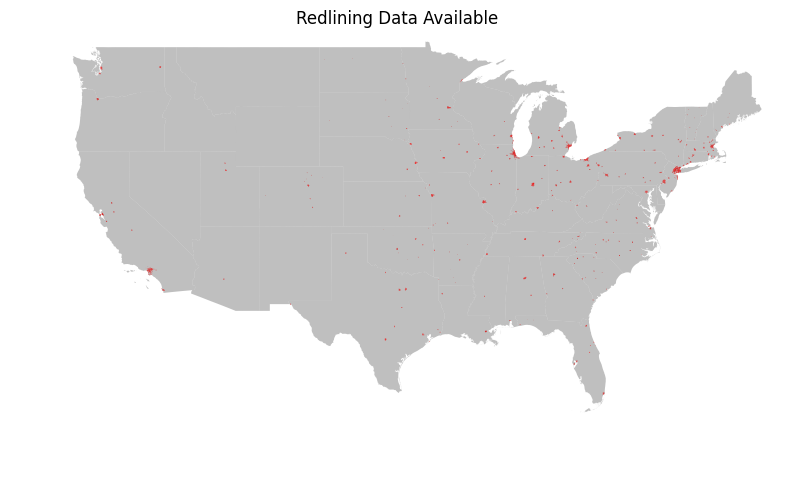

In [8]:
# Now we can take a look at the redline data on a map.
plt.figure(figsize=(10, 10))
plt.title("Redlining Data Available")
plt.axis("off")

us_map.plot(ax=plt.gca(), facecolor="gray", alpha=0.5)
redline_data.plot(ax=plt.gca(), facecolor="red")
plt.ylim(20, 50)
plt.xlim(-130, -65)

In [9]:
# Convert CDC data into a proper geodataframe with geolocation points properly parsed.
# I don't like to have had to do this, given it was already written so close to the desired format...
cdc_data = gpd.GeoDataFrame(cdc_data, geometry = gpd.points_from_xy(cdc_data['Geolocation'].str.extract(r'POINT \(([-\d\.]+) ([-\d\.]+)\)')[0], cdc_data['Geolocation'].str.extract(r'POINT \(([-\d\.]+) ([-\d\.]+)\)')[1]))
cdc_data = cdc_data.drop(["Geolocation"], axis=1)

(-180.0, -55.0)

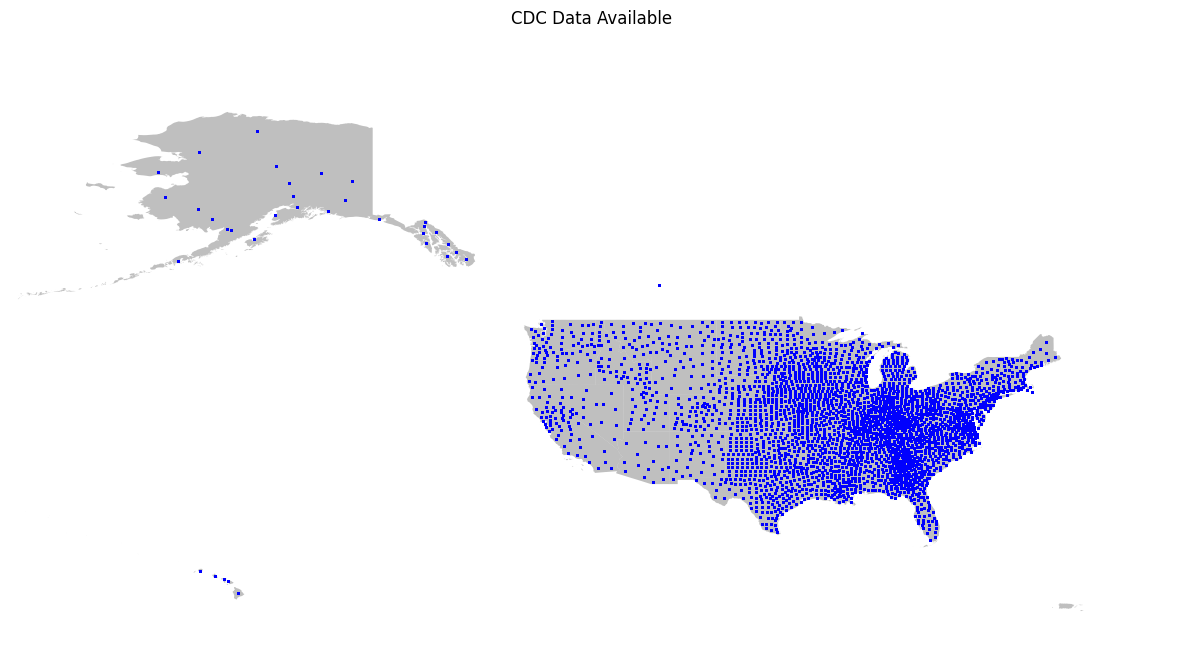

In [10]:
# We can also look at the CDC data.
plt.figure(figsize=(15, 15))
plt.title("CDC Data Available")
plt.axis("off")

us_map.plot(ax=plt.gca(), facecolor="gray", alpha=0.5)
cdc_data.plot(ax=plt.gca(), color="blue", markersize=1)
plt.ylim(15, 80)
plt.xlim(-180, -55)

In [11]:
# This data's crs is WGS84, so let's assign it.
cdc_data.crs = "EPSG:4326"

# Now we reproject redline data to CDC coordinates.
redline_data = redline_data.to_crs(cdc_data.crs)


# Now we reproject the cdc data again to add a buffer.
# https://stackoverflow.com/questions/72073417/userwarning-geometry-is-in-a-geographic-crs-results-from-buffer-are-likely-i
# The buffer is necessary so we can detect which areas in the redline data are close enough to areas in the CDC data to consider.
cdc_data = cdc_data.to_crs(crs=3857)
cdc_data["geometry"] = cdc_data.buffer(1000.0) # The bigger the number, the less precise, but also more data we get, I think.
cdc_data = cdc_data.to_crs(redline_data.crs)

(-180.0, -55.0)

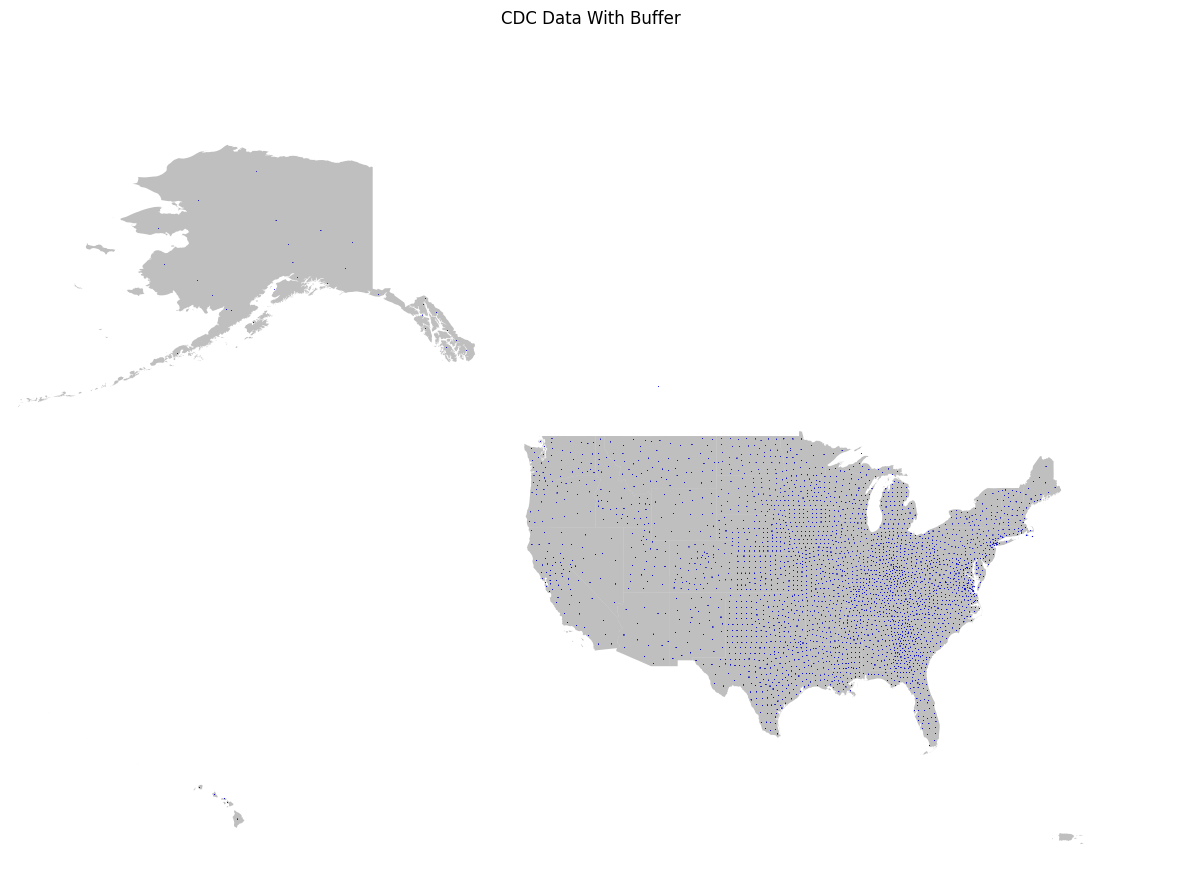

In [12]:
# Now we can plot the data to see the sizes of our buffered data points.
plt.figure(figsize=(15, 15))
plt.title("CDC Data With Buffer")
plt.axis("off")

us_map.plot(ax=plt.gca(), facecolor="gray", alpha=0.5)
cdc_data.plot(ax=plt.gca(), color="blue")
plt.ylim(15, 80)
plt.xlim(-180, -55)

In [13]:
# check whether each point in the CDC data falls into the redlining geometry
# cdc_redline_intersects = gpd.overlay(cdc_data, redline_data, how='intersection')

# Spatial join: keeps all points, adds redline attributes where they intersect
cdc_with_redline_flag = gpd.sjoin(
    cdc_data,
    redline_data,
    how="left",   # keeps all CDC points
    predicate="intersects"
)

# Create a flag column
cdc_with_redline_flag["in_redline"] = cdc_with_redline_flag.index_right.notnull()
cdc_redline_intersects = cdc_with_redline_flag[cdc_with_redline_flag["in_redline"] == True].drop(["index_right", "in_redline"], axis=1)

In [14]:
# the remaining data should be just the parts of the CDC data that are included in the redlining data
cdc_redline_intersects.shape

(17030, 33)

In [15]:
# The geometry itself matters very little; the big gain from creating the GeoDataFrame above is figuring out locations overlap.
# Now we list all the column names so that we can go through them one by one and decide what to do with them.
cdc_redline_intersects.columns

Index(['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource',
       'Category', 'Measure', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation',
       'TotalPop18plus', 'LocationID', 'CategoryID', 'MeasureId',
       'DataValueTypeID', 'Short_Question_Text', 'geometry', 'area_id', 'city',
       'state', 'city_survey', 'category', 'grade', 'label', 'residential',
       'commercial', 'industrial', 'fill'],
      dtype='object')

In [16]:
# Year
cdc_redline_intersects["Year"].value_counts()

,count
Year,
2022,15238
2021,1792


In [17]:
# there's no reason to keep both StateAbbr and StateDesc, so we'll drop StateAbbr
cdc_redline_intersects = cdc_redline_intersects.drop(["StateAbbr"], axis=1)
# now we create dummies for state
cdc_redline_intersects = pd.get_dummies(cdc_redline_intersects, columns=["StateDesc"])

In [18]:
# location ID and LocationName both describe the county
# location ID is less readable, so let's drop it
cdc_redline_intersects = cdc_redline_intersects.drop(["LocationID"], axis=1)
# dummies for location name, as above
cdc_redline_intersects = pd.get_dummies(cdc_redline_intersects, columns=["LocationName"])

In [19]:
print(cdc_redline_intersects["DataSource"].value_counts())
# All the data is from the same source; this column should be dropped.
cdc_redline_intersects = cdc_redline_intersects.drop(["DataSource"], axis=1)

DataSource
BRFSS    17030
Name: count, dtype: int64


In [20]:
# I'm going to drop the confidence limits columns, since it seems wrong to use them as predictive values.
cdc_redline_intersects = cdc_redline_intersects.drop(["Low_Confidence_Limit", "High_Confidence_Limit"], axis=1)

In [21]:
# TotalPopulation and TotalPop18Plus are fine as-is.
# 'CategoryID', 'MeasureId', 'DataValueTypeID' are redundant.
cdc_redline_intersects = cdc_redline_intersects.drop(["CategoryID", "MeasureId", "DataValueTypeID"], axis=1)

In [22]:
# short question text, redundant with measure
cdc_redline_intersects = cdc_redline_intersects.drop(["Short_Question_Text"], axis=1)

In [23]:
# Drop area_id; it's somewhat redundant...
cdc_redline_intersects = cdc_redline_intersects.drop(["area_id"], axis=1)

In [24]:
# Create dummies for city.
cdc_redline_intersects = pd.get_dummies(cdc_redline_intersects, columns=["city"])

In [25]:
# State is redundant with StateDesc.
cdc_redline_intersects = cdc_redline_intersects.drop(["state"], axis=1)

In [26]:
# Category is just a description of Grade and can be dropped.
cdc_redline_intersects = cdc_redline_intersects.drop(["category"], axis=1)

In [27]:
# Label is not useful.
cdc_redline_intersects = cdc_redline_intersects.drop(["label"], axis=1)

In [28]:
# Fill and geometry are no longer relevant and can also be dropped.
cdc_redline_intersects = cdc_redline_intersects.drop(["fill", "geometry"], axis=1)

In [29]:
# Without fill and geometry, we can convert the GeoDataFrame into a normal DataFrame.
cdc_redline_intersects = pd.DataFrame(cdc_redline_intersects)

In [30]:
cdc_redline_intersects["Data_Value_Type"].value_counts()

,count
Data_Value_Type,
Crude prevalence,8515
Age-adjusted prevalence,8515


In [31]:
# Unfortunately, we'll be shrinking our data quite a lot with the next few steps
# Drop all rows where the Data Value Type is Crude Prevalence, as we already have age-adjusted equivalents.
cdc_redline_intersects = cdc_redline_intersects[cdc_redline_intersects["Data_Value_Type"] != "Crude prevalence"]

In [32]:
# Now we drop all the remaining rows describing the data value (except the main one.)
# All values are expressed as percentages.
cdc_redline_intersects = cdc_redline_intersects.drop(["Data_Value_Type", "Data_Value_Unit", "Data_Value_Footnote_Symbol", "Data_Value_Footnote"], axis=1)

In [33]:
# And we'll also be dropping category; measure is more specific.
cdc_redline_intersects = cdc_redline_intersects.drop(["Category"], axis=1)

In [34]:
cdc_redline_intersects["grade"].value_counts()

,count
grade,
C,2362
D,1952
B,1302
A,824
,610
E,33


In [35]:
# We'll be using mapping to turn the grade into numbers (label encoding).
cdc_redline_intersects["grade"] = cdc_redline_intersects["grade"].map({"A": 4, "B": 3, "C": 2, "D": 1, "E": 0})

In [36]:
# We'll drop rows with missing values now. Grade is the measure we care about the most, so there's no need to keep rows without it.
cdc_redline_intersects = cdc_redline_intersects.dropna()

In [37]:
# We'll convert all "True" and "False" into 1 and 0.
cdc_redline_intersects = cdc_redline_intersects.replace({"True": 1, "False": 0})

/tmp/ipython-input-254286656.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cdc_redline_intersects = cdc_redline_intersects.replace({"True": 1, "False": 0})


In [38]:
# We're going to be making separate models to predict each measure, so the count for each row is the amount of data we have for each model.
cdc_redline_intersects["Measure"].value_counts()

,count
Measure,
Stroke among adults,172
Arthritis among adults,172
Frequent mental distress among adults,172
Current asthma among adults,172
Coronary heart disease among adults,172
Fair or poor self-rated health status among adults,172
No leisure-time physical activity among adults,172
Binge drinking among adults,172
Visits to doctor for routine checkup within the past year among adults,172


#Training Models

In [39]:
# There's very little data; the best I can think to do is train a model for each measure.

# This article here: https://machinelearningmastery.com/logistic-vs-svm-vs-random-forest-which-one-wins-for-small-datasets/
# compares some models' performance with small datasets. Seems like a good starting point.

In [54]:
# Define some functions for making a series of models and displaying their average coefficients.

def make_pipes(model, param_list):
  cdc_measures = cdc_redline_intersects["Measure"].unique()
  pipes = []
  for measure_name in cdc_measures:
      measure_df = cdc_redline_intersects[cdc_redline_intersects["Measure"] == measure_name]
      measure_df = measure_df.drop(["Measure"], axis=1)
      X_train, X_test, y_train, y_test = train_test_split(measure_df.drop(["Data_Value"], axis=1), measure_df["Data_Value"], test_size=0.2)

      measure_pipe = Pipeline([
          ("scaler", StandardScaler()),
          ("grid", GridSearchCV(model, param_list))
      ])

      measure_pipe.fit(X_train, y_train)
      pipes.append((measure_name, measure_pipe))
  return pipes, X_test, y_test


# It's simpler to make a separate function that to adjust the one above.
def make_pipes_just_grade(model, param_list):
  cdc_measures = cdc_redline_intersects["Measure"].unique()
  pipes = []
  for measure_name in cdc_measures:
      measure_df = cdc_redline_intersects[cdc_redline_intersects["Measure"] == measure_name]
      measure_df = measure_df.drop(["Measure"], axis=1)
      X_train, X_test, y_train, y_test = train_test_split(measure_df[["grade"]], measure_df["Data_Value"], test_size=0.2)

      measure_pipe = Pipeline([
          ("scaler", StandardScaler()),
          ("grid", GridSearchCV(model, param_list))
      ])

      measure_pipe.fit(X_train, y_train)
      pipes.append((measure_name, measure_pipe))
  return pipes, X_test, y_test


def print_average_score(pipes):
  avg_score = 0
  for pipe_tuple in pipes:
    # print(pipe_tuple[0], pipe_tuple[1].named_steps["grid"].best_score_)
    avg_score += pipe_tuple[1].named_steps["grid"].best_score_
  avg_score /= len(pipes)
  print("Average score:", avg_score)


# Unused for parity with SVM results, but a decent pice of code nonetheless.
def print_average_coefs(pipes):
  average_coef = np.zeros(len(pipes[0][1].named_steps["grid"].best_estimator_.coef_))

  for pipe_tuple in pipes:
    for i in range(len(pipe_tuple[1].named_steps["grid"].best_estimator_.coef_)):
      average_coef[i] += pipe_tuple[1].named_steps["grid"].best_estimator_.coef_[i]
  average_coef /= len(pipes)

  # Now put the averaged coefficients into something readable...
  column_headers = list(cdc_redline_intersects.columns)
  column_headers.remove("Data_Value")
  column_headers.remove("Measure")

  average_coef_table = pd.DataFrame(abs(average_coef), index=column_headers, columns=["Coefficient"])
  print(average_coef_table.sort_values(by="Coefficient", ascending=False))


def print_average_feature_importances(pipes, X_test, y_test):
  average_feature_importances = np.zeros(X_test.shape[1])

  for pipe_tuple in pipes:
    best_estimator = pipe_tuple[1].named_steps["grid"].best_estimator_
    X_test_scaled = pipe_tuple[1].named_steps["scaler"].transform(X_test)
    y_pred = best_estimator.predict(X_test_scaled)
    # print(pipe_tuple[0], r2_score(y_test, y_pred))
    pipe_permutation_importance = permutation_importance(best_estimator, X_test_scaled, y_pred, n_repeats=10, random_state=42)
    average_feature_importances += pipe_permutation_importance.importances_mean
  average_feature_importances /= len(pipes)

  # Now put the averaged coefficients into something readable...
  column_headers = list(X_test.columns)

  average_coef_table = pd.DataFrame(average_feature_importances, index=column_headers, columns=["Importance"])
  print(average_coef_table.sort_values(by="Importance", ascending=False))

In [51]:
linreg_params = {
    "fit_intercept": [True, False]
}

pd.options.display.max_rows = 250
linreg_pipes, X_test, y_test = make_pipes(LinearRegression(), linreg_params)

In [43]:
print_average_score(linreg_pipes)
print_average_feature_importances(linreg_pipes, X_test, y_test)

Average score: 0.8480161060836945
                            Importance
LocationName_San Francisco    0.050020
city_San Francisco            0.050020
city_Madison                  0.046849
LocationName_Dane             0.046849
LocationName_Clark            0.041292
city_Springfield              0.041292
StateDesc_California          0.037489
StateDesc_Ohio                0.020801
StateDesc_Wisconsin           0.020116
StateDesc_New Jersey          0.017964
city_Knoxville                0.015897
LocationName_Knox             0.015897
StateDesc_Texas               0.014925
city_Baltimore                0.013108
StateDesc_Maryland            0.013108
LocationName_Baltimore        0.013108
city_San Antonio              0.012721
LocationName_Bexar            0.012721
city_Union Co.                0.012258
LocationName_Union            0.012258
city_Essex Co.                0.012156
LocationName_Essex            0.012156
city_Canton                   0.010361
LocationName_Stark            

In [44]:
svm_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

#disable warnings
import warnings
warnings.filterwarnings("ignore")
svm_pipes, X_test, y_test = make_pipes(SVC(), svm_params)

In [45]:
print_average_score(svm_pipes)
print_average_feature_importances(svm_pipes, X_test, y_test)

Average score: 0.888389724310777
                            Importance
StateDesc_California          0.016957
city_San Antonio              0.015652
LocationName_Bexar            0.015652
LocationName_Jackson          0.014674
city_Jackson                  0.014674
city_Lexington                0.011957
LocationName_Fayette          0.011957
StateDesc_Kentucky            0.011957
city_Essex Co.                0.011522
LocationName_Essex            0.011522
LocationName_San Francisco    0.011196
city_San Francisco            0.011196
city_Madison                  0.011196
LocationName_Dane             0.011196
LocationName_Montgomery       0.010870
city_Dayton                   0.010870
city_Stockton                 0.009457
LocationName_San Joaquin      0.009457
LocationName_Mecklenburg      0.008478
city_Charlotte                0.008478
city_Knoxville                0.007826
LocationName_Knox             0.007826
LocationName_Lucas            0.006739
city_Toledo                   0

In [55]:
# Now we'll be training similar models on JUST grade.
linreg_pipes_just_grade, X_test, y_test = make_pipes_just_grade(LinearRegression(), linreg_params)
print_average_score(linreg_pipes_just_grade)
print_average_feature_importances(linreg_pipes_just_grade, X_test, y_test)

Average score: -0.031694188611112444
       Importance
grade    2.037719


In [56]:
svm_pipes_just_grade, X_test, y_test = make_pipes_just_grade(SVC(), svm_params)
print_average_score(svm_pipes_just_grade)
print_average_feature_importances(svm_pipes_just_grade, X_test, y_test)

Average score: 0.11132066276803118
       Importance
grade    0.533261
